### Imports

In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

DATASET_PATH = '../data/augmented/'
TEST_DATASET_PATH = '../data/test/'

### Read augmented images from folder

In [2]:
def read_files(path):
    files = os.listdir(path)
    rawx=[]
    rawy=[]
    random.shuffle(files)
    for file in files:
        img = cv2.imread(os.path.join(path,file),cv2.IMREAD_GRAYSCALE)
        rawx.append(img)
        rawy.append(int(file.split('_')[1]))
    h, w = rawx[0].shape
    rawx = np.asarray(rawx)
    rawy = np.asarray(rawy)
    rawx = rawx.reshape(len(files),h, w, 1)
    rawx = rawx / 255.
    return rawx, rawy, h, w

In [3]:
xtrain, ytrain, im_h, im_w = read_files(DATASET_PATH)
num_classes = len(np.unique(ytrain))

In [4]:
np.unique(ytrain, return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([1500, 1500, 1500, 1500, 1500, 1500], dtype=int64))

### Read test images from originals_test folder

In [5]:
xtest, ytest, im_h, im_w = read_files(TEST_DATASET_PATH)

### Check how the images looks like

In [6]:
def plot_6_images(xt,yt):
    
    idxs = [ random.randint(0,len(xt)) for i in range(0,6)]
    plt.figure(figsize=(10,5))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(xt[idxs[i]].reshape(im_w,im_h),cmap='gray')
        plt.title('y={}'.format(yt[idxs[i]]))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()  

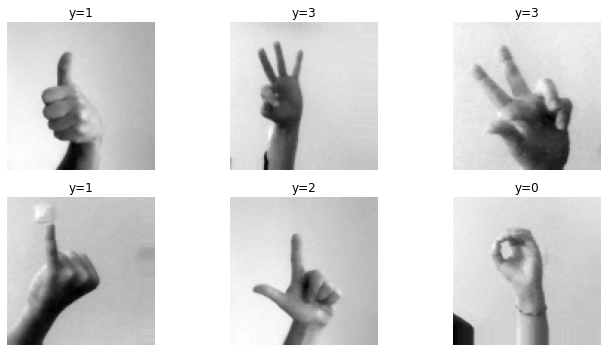

In [7]:
plot_6_images(xtrain,ytrain)

### Create Keras FC Model

In [8]:
from keras.backend import clear_session

clear_session()
model = None

Using TensorFlow backend.


In [9]:
from keras.utils import to_categorical

ytrain_cat = to_categorical(ytrain, num_classes)
ytest_cat = to_categorical(ytest, num_classes)

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD, Adam, Adadelta
from keras.metrics import categorical_accuracy

model = Sequential()

model.add(Flatten(input_shape=(im_w,im_h,1)))
model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.125))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(6, activation="softmax"))

model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=[categorical_accuracy])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                

### Train FC NN

In [11]:
from keras.callbacks import EarlyStopping
EPOC = 25
# BS = 64
# batch_size=BS,

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
history = model.fit(xtrain, ytrain_cat, validation_split=0.2,  epochs=EPOC, callbacks=[es])


Train on 7200 samples, validate on 1800 samples
Epoch 1/25
7200/7200 [==============================] - 5s 658us/step - loss: 1.9070 - categorical_accuracy: 0.1628 - val_loss: 1.7919 - val_categorical_accuracy: 0.1628
Epoch 2/25
7200/7200 [==============================] - 4s 598us/step - loss: 1.7950 - categorical_accuracy: 0.1668 - val_loss: 1.7919 - val_categorical_accuracy: 0.1628
Epoch 3/25
7200/7200 [==============================] - 4s 598us/step - loss: 1.7939 - categorical_accuracy: 0.1586 - val_loss: 1.7920 - val_categorical_accuracy: 0.1628
Epoch 4/25
7200/7200 [==============================] - 9s 1ms/step - loss: 1.7975 - categorical_accuracy: 0.1683 - val_loss: 1.7984 - val_categorical_accuracy: 0.1661
Epoch 5/25
7200/7200 [==============================] - 4s 605us/step - loss: 1.7922 - categorical_accuracy: 0.1689 - val_loss: 1.7919 - val_categorical_accuracy: 0.1633
Epoch 6/25
7200/7200 [==============================] - 4s 605us/step - loss: 1.7921 - categorical_accur

In [12]:
history.params

{'batch_size': 32,
 'epochs': 25,
 'steps': None,
 'samples': 7200,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss',
  'categorical_accuracy',
  'val_loss',
  'val_categorical_accuracy']}

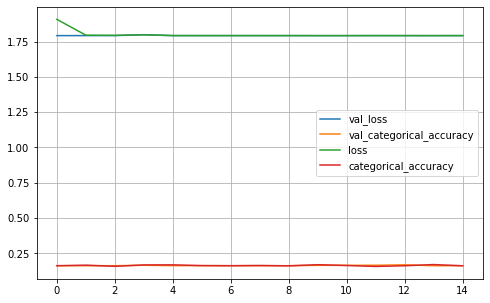

In [13]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.show()